In [1]:
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [2]:
DATA_PATH = Path.cwd().parent.joinpath('data', 'raw', 'market_values.csv')

In [3]:
market_values = pd.read_csv(DATA_PATH, usecols=
                            [
                                'fyearq', 'fqtr', 'fyr', 'indfmt', 'consol', 'popsrc',
                                'datafmt', 'tic', 'conm', 'curcdq', 'datacqtr', 'datafqtr',
                                'exchg', 'costat', 'fic', 'mkvaltq'
                            ]
                           )

In [4]:
market_values.head()

,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,conm,curcdq,datacqtr,datafqtr,exchg,costat,fic,mkvaltq
0,2000,1.0,12,INDL,C,D,STD,ABF,AIRBORNE INC,USD,2000Q1,2000Q1,11,I,USA,NaN
1,2000,2.0,12,INDL,C,D,STD,ABF,AIRBORNE INC,USD,2000Q2,2000Q2,11,I,USA,NaN
2,2000,3.0,12,INDL,C,D,STD,ABF,AIRBORNE INC,USD,2000Q3,2000Q3,11,I,USA,NaN
3,2000,4.0,12,INDL,C,D,STD,ABF,AIRBORNE INC,USD,2000Q4,2000Q4,11,I,USA,NaN
4,2001,1.0,12,INDL,C,D,STD,ABF,AIRBORNE INC,USD,2001Q1,2001Q1,11,I,USA,NaN


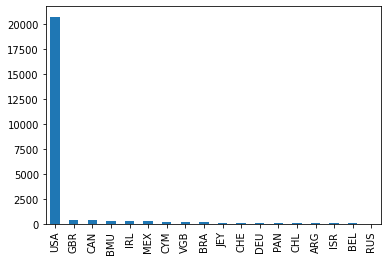

In [5]:
market_values.fic.value_counts().plot(kind='bar')

In [6]:
def get_bad_data(market_values):
    bad_data = list()
    for ticker in market_values.tic.unique():
        subset = market_values[market_values.tic==ticker]
        current = 'na' if np.isnan(subset.mkvaltq.iloc[0]) else 'val'
        for v in subset.mkvaltq[1:]:
            if not np.isnan(v):
                current = 'val'
            elif current == 'val' and np.isnan(v):
                bad_data.append((ticker, subset.conm.iloc[0]))
                continue
    return Counter(bad_data)

In [7]:
bad_data_1 = get_bad_data(market_values)
bad_data_1

Counter({('DAN', 'DANA INC'): 1,
         ('DG', 'DOLLAR GENERAL CORP'): 10,
         ('GM', 'GENERAL MOTORS CO'): 1,
         ('KHC', 'KRAFT HEINZ CO'): 10,
         ('LZB', 'LA-Z-BOY INC'): 1,
         ('JEF', 'JEFFERIES FINANCIAL GRP INC'): 1,
         ('NATR', 'NATURES SUNSHINE PRODS INC'): 4,
         ('CCL', 'CARNIVAL CORPORATION & PLC'): 5,
         ('NBEV', 'NEWAGE INC'): 2,
         ('SMPL', 'SIMPLY GOOD FOODS COMPANY'): 5,
         ('PFGC', 'PERFORMANCE FOOD GROUP CO'): 32,
         ('KDP', 'KEURIG DR PEPPER INC'): 10,
         ('LMNR', 'LIMONEIRA CO'): 4,
         ('BTH', 'BLYTH INC'): 1,
         ('BEAM', 'BEAM THERAPEUTICS INC'): 1,
         ('NHTC', 'NATURAL HEALTH TRENDS CORP'): 3,
         ('JAKK', 'JAKKS PACIFIC INC'): 1,
         ('TTWO', 'TAKE-TWO INTERACTIVE SFTWR'): 2,
         ('AIPC', 'AMER ITALIAN PASTA CO  -CL A'): 3,
         ('SVM', 'SILVERCORP METALS INC'): 4,
         ('APTV', 'APTIV PLC'): 9,
         ('SEED', 'ORIGIN AGRITECH LTD'): 7,
         ('CELH', '

In [8]:
for elem in bad_data_1.items():
    if elem[1] == 1:
        subset = market_values[market_values.tic == elem[0][0]]
        ind = subset[subset.mkvaltq.isna()].index[-1]
        if ind == subset.index[-1]:
            subset.loc[ind, 'mkvaltq'] = subset.loc[ind-1, 'mkvaltq']
        else:
            subset.loc[ind, 'mkvaltq'] = (subset.loc[ind-1, 'mkvaltq'] + subset.loc[ind+1, 'mkvaltq']) / 2
        market_values[market_values.tic == elem[0][0]] = subset

/home/cspa33/miniconda3/envs/ORIE5370/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [9]:
get_bad_data(market_values)

Counter({('DG', 'DOLLAR GENERAL CORP'): 10,
         ('KHC', 'KRAFT HEINZ CO'): 10,
         ('NATR', 'NATURES SUNSHINE PRODS INC'): 4,
         ('CCL', 'CARNIVAL CORPORATION & PLC'): 5,
         ('NBEV', 'NEWAGE INC'): 2,
         ('SMPL', 'SIMPLY GOOD FOODS COMPANY'): 5,
         ('PFGC', 'PERFORMANCE FOOD GROUP CO'): 32,
         ('KDP', 'KEURIG DR PEPPER INC'): 10,
         ('LMNR', 'LIMONEIRA CO'): 4,
         ('NHTC', 'NATURAL HEALTH TRENDS CORP'): 3,
         ('TTWO', 'TAKE-TWO INTERACTIVE SFTWR'): 2,
         ('AIPC', 'AMER ITALIAN PASTA CO  -CL A'): 3,
         ('SVM', 'SILVERCORP METALS INC'): 4,
         ('APTV', 'APTIV PLC'): 9,
         ('SEED', 'ORIGIN AGRITECH LTD'): 7,
         ('CZZ', 'COSAN LTD'): 2,
         ('NOMD', 'NOMAD FOODS LTD'): 2})

In [10]:
last_mkt_cap = list()
for tick in market_values.tic.unique():
    subset = market_values[market_values.tic == tick]
    val = subset.mkvaltq.values[-1]
    if not np.isnan(val):
        if val*1_000_000 < 0.2*100_000_000_000:
#             print(f'{tick}: {val*1_000_000:,}')
            last_mkt_cap.append(subset.mkvaltq.values[-1]*1_000_000)

(array([73., 50., 31., 21., 10., 12., 17.,  9., 11.,  7.,  5.,  6.,  5.,
         3.,  1.,  5.,  0.,  3.,  1.,  1.]),
 array([2.14600000e+05, 9.50816010e+08, 1.90141742e+09, 2.85201883e+09,
        3.80262024e+09, 4.75322165e+09, 5.70382306e+09, 6.65442447e+09,
        7.60502588e+09, 8.55562729e+09, 9.50622870e+09, 1.04568301e+10,
        1.14074315e+10, 1.23580329e+10, 1.33086343e+10, 1.42592358e+10,
        1.52098372e+10, 1.61604386e+10, 1.71110400e+10, 1.80616414e+10,
        1.90122428e+10]),
 <a list of 20 Patch objects>)

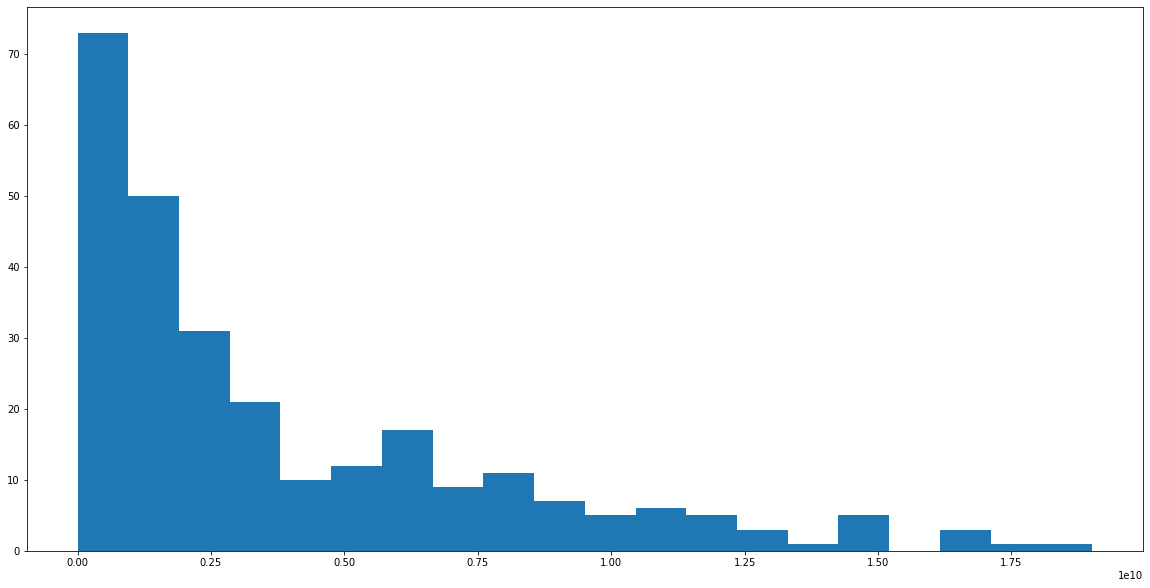

In [11]:
plt.figure(figsize=(20,10))
plt.hist(last_mkt_cap, bins=20)

In [12]:
returns = {'small': [], 'big': []}

for tick in tqdm_notebook(market_values.tic.unique()):
    subset = market_values[market_values.tic == tick]
    r = yf.download(tick, start='2000-01-01', end='2020-12-31', interval='3mo', progress=False)
    r['return'] = r.Close.pct_change()
    if subset.mkvaltq.values[-1] > 100_000_000_000:
        returns['big'].append(r['return'].mean())
    else:
        returns['small'].append(r['return'].mean())

<ipython-input-12-2cd50525494d>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tick in tqdm_notebook(market_values.tic.unique()):


  0%|          | 0/372 [00:00<?, ?it/s]


1 Failed download:
- AVP: No data found, symbol may be delisted

1 Failed download:
- BOBE: No data found for this date range, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted

1 Failed download:
- CDSCY: No data found, symbol may be delisted

1 Failed download:
- CHTT: No data found for this date range, symbol may be delisted

1 Failed download:
- DRYR: No data found for this date range, symbol may be delisted

1 Failed download:
- KTII: No data found for this date range, symbol may be delisted

1 Failed download:
- KWD: No data found for this date range, symbol may be delisted

1 Failed download:
- LNCE: No data found for this date range, symbol may be delisted

1 Failed download:
- KATE: No data found for this date range, symbol may be delisted

1 Failed download:
- RYL: No data found for this date range, symbol may be delisted

1 Failed download:
- SWY: No data found for this date range, symbol may be delisted

1 Failed d

In [13]:
test = yf.download('RNDY', start='2000-01-01', end='2020-12-31', interval='3mo', progress=False)


1 Failed download:
- RNDY: No data found for this date range, symbol may be delisted


In [14]:
for item in returns.items():
    print(f'{item[0]}: {np.mean(item[1])}')

small: nan
big: nan


/home/cspa33/miniconda3/envs/ORIE5370/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cspa33/miniconda3/envs/ORIE5370/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
np.mean()

TypeError: _mean_dispatcher() missing 1 required positional argument: 'a'